# 1. Install and import dependencies

## Installation

The first step is to install all the necessary libraries. 

1. Machine Learning libraries:

**- TensorFlow:** For this project, I will use TensorFlow, and as I am using an Apple silicon Mac, I will be running TensorFlow in the Metal API. 

**- Scikit-Learn:** This library is leveraged to split training and testing data and to quantify the precision or the likelihood of the speaker expressing a word on the real-time video feed.

2. Computer Vision libraries:

**- OpenCV** is an open-source Computer Vision library, in this project it is used to enable webcam activation.
**- MediaPipe Holistic** is used to track hand and face features by extracting keypoints.

3. Plotting library:

**- Matplotlib** is used for visual representation of data.

In [1]:
!pip install tensorflow tensorflow-metal opencv-python mediapipe scikit-learn matplotlib

Installation test for MacOS; the following code is a test to see if tensorflow is installed correclty and if it runs smoothly on the Metal API.

import tensorflow as tf

cifar = tf.keras.datasets.cifar100
(x_train, y_train), (x_test, y_test) = cifar.load_data()
model = tf.keras.applications.ResNet50(
    include_top=True,
    weights=None,
    input_shape=(32, 32, 3),
    classes=100,)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
model.fit(x_train, y_train, epochs=5, batch_size=64)

## Import

In [2]:
import cv2                                  # Import OpenCV
import numpy as np                          # Import NumPy to help structure arrays (datasets)
import os                                   # To easier work with filepaths
from matplotlib import pyplot as plt        # Import pyplot from Matplotlib
import time                                 # Import time
import mediapipe as mp                      # Import MediaPipe

# 2. Access to webcam using OpenCV and keypoints detection using MediaPipe

In [3]:
# Holistic model to make detection
mp_holistic = mp.solutions.holistic 

# Drawing utilities to draw detection
mp_drawing = mp.solutions.drawing_utils 

In [4]:
# Function to make the detection
def mediapipe_detection(image, model):
    # Convert colors from BGR to RGB (needs to be RGB to make detection in MediaPipe)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    # To save space --> make unwriteable image
    image.flags.writeable = False  
    # Make prediction
    results = model.process(image) 
    # Convert back to writeable image
    image.flags.writeable = True  
    # Convert colors from BGR to RGB                 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

In [5]:
def draw_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(236,138,26), thickness=1, circle_radius=1),  # dot color (remember colors are in BGR )  
                             mp_drawing.DrawingSpec(color=(236,208,26), thickness=1, circle_radius=1)   # line color
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(186,52,25), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(236,103,26), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(0,153,0), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(51,255,51), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(255,255,0), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(255,255,102), thickness=2, circle_radius=2)
                             ) 

In [6]:
# Access webcam (video capture device 0 should be the webcam)
cap = cv2.VideoCapture(0)

# Set MediaPipe model 
# What MediaPipe initially does is it detects the keypoints and then tracks
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # Loop through the camera
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read() # return value and frame
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        # Draw landmarks
        draw_landmarks(image, results)
        # Show to screen
        cv2.imshow('Webcam Feed', image)
        # Break out of the loop
        if cv2.waitKey(10) & 0xFF == ord('q'):  # if 'q' is hit in keyboard
            break
        
    cap.release()
    cv2.destroyAllWindows()

I0000 00:00:1718825193.972249       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3 Max
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

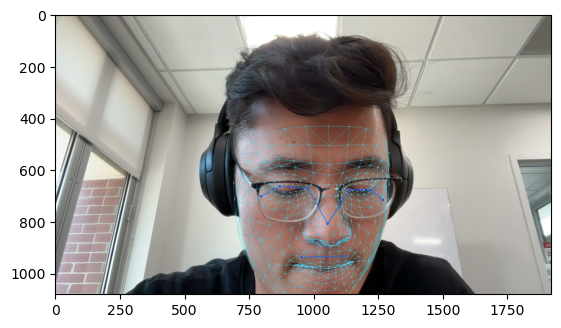

In [7]:
# We have access to the last frame
draw_landmarks(frame, results)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

Extract keypoints values into a NumPy array. If no results are gotten in a frame (instance), there will be incompatibility issues as the array will not have the same size. In those cases, a NumPy array of zeros with the same size is leveraged.

print("Length of pose landmarks:", len(results.pose_landmarks.landmark))
print("Length of face landmarks:", len(results.face_landmarks.landmark))
print("Length of left hand landmarks:", len(results.left_hand_landmarks.landmark))
print("Length of right hand landmarks:", len(results.right_hand_landmarks.landmark))

pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten()
print("Pose shape:", pose.shape)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten()
print("Face shape:", face.shape)
left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() 
print("Left hand shape:", left_hand.shape)
right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten()
print("Right hand shape:", right_hand.shape)

In [6]:
def keypoints_extraction(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    # face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)                # multiplied by 3 as it has x, y and z components
    left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(63)  
    right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(63)
    return np.concatenate([pose, left_hand, right_hand]) # no face

In [16]:
result_test = keypoints_extraction(results)
result_test.shape

(258,)

In [10]:
np.save('0', result_test)   # save NumPy array called 0 as .npy

In [11]:
np.load('0.npy')

array([ 5.49656868e-01,  7.48382032e-01, -2.03418446e+00,  9.96142626e-01,
        5.93878686e-01,  6.27472997e-01, -1.96197426e+00,  9.96683896e-01,
        6.18239284e-01,  6.27375364e-01, -1.96250498e+00,  9.96934772e-01,
        6.37689471e-01,  6.28162384e-01, -1.96271467e+00,  9.96444821e-01,
        5.10308981e-01,  6.23229325e-01, -1.97285330e+00,  9.96470928e-01,
        4.79311913e-01,  6.19171381e-01, -1.97332060e+00,  9.96320069e-01,
        4.52986598e-01,  6.15649700e-01, -1.97365355e+00,  9.95915353e-01,
        6.61206305e-01,  6.64238453e-01, -1.31557786e+00,  9.97432292e-01,
        4.15123492e-01,  6.51307762e-01, -1.34606004e+00,  9.96597052e-01,
        5.86145580e-01,  8.64091218e-01, -1.75796497e+00,  9.88579690e-01,
        4.97844368e-01,  8.69146645e-01, -1.77482963e+00,  9.87717390e-01,
        7.64756560e-01,  1.04801416e+00, -8.83282781e-01,  8.70867610e-01,
        2.39541873e-01,  1.05821502e+00, -7.06238985e-01,  8.33810985e-01,
        8.61640215e-01,  

# 4. Setup for data collection

In [38]:
# Path for exported data, these are numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['Hello','Thank you', 'I love you', 'How are you?', 'Nice to meet you!', "What's your name?", 'Deaf', 'Hard of hearing', 'Goodbye','Sorry', 'Please','Good', 'Fine', 'Bad','Excuse me', 'Good morning', 'Good night', 'Hungry', 'Tired', 'Help', 'Busy', 'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','1','2','3','4','5','10','11','12','13','14','15','20'])
#actions = np.array(['Hello','Thank you', 'I love you', 'How are you?', 'Nice to meet you!', "What's your name?", 'Deaf', 'Hard of hearing', 'Goodbye','Sorry', 'Please','Good', 'Fine', 'Bad','Excuse me', 'Good morning', 'Good night', 'Hungry', 'Tired', 'Help', 'Busy', 'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','1','2','3','4','5','10','11','12','13','14','15','20'])

# Number of videos collected per action
no_sequences = 30

# 30 frames each video
sequence_length = 30

# Folder start
start_folder = 30

# Create folders where data is stored
for action in actions:      # loop through actions
    for sequence in range(no_sequences):     # loop through videos
        try:    # just in case the directories are created already to avoid errors
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))  # a folder is created called 'MP_Data', then inside it another folder for each action, and within in action there will be a folder for each sequence/video
        except: # if the folder is created, skip making the directory
            pass

# 5. Collect Keypoint Values for Training and Testing

In [104]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # Loop through actions
    for action in actions:
        # Loop through sequences/videos
        for sequence in range(no_sequences):
        
            # Loop through video length
            for frame_num in range(sequence_length):
                # Read feed
                ret, frame = cap.read()
                # Make detections
                image, results = mediapipe_detection(frame, holistic)
                # Draw landmarks
                draw_landmarks(image, results)
                # Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), # x and y values of pixels where it is going to be displayed
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA) # font, font size, color in BGR, line width and line type
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('Webcam Feed', image)
                    cv2.waitKey(1000)    # wait half a second
                else: # if not in frame 0
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('Webcam Feed', image)
                
                # Extract and export keypoints
                keypoints = keypoints_extraction(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

I0000 00:00:1719791440.211170       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M3 Max


# 6. Data Preprocessing

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [39]:
label_map = {label:num for num, label in enumerate(actions)}

In [40]:
label_map

{'Hello': 0,
 'Thank you': 1,
 'I love you': 2,
 'How are you?': 3,
 'Nice to meet you!': 4,
 "What's your name?": 5,
 'Deaf': 6,
 'Hard of hearing': 7,
 'Goodbye': 8,
 'Sorry': 9,
 'Please': 10,
 'Good': 11,
 'Fine': 12,
 'Bad': 13,
 'Excuse me': 14,
 'Good morning': 15,
 'Good night': 16,
 'Hungry': 17,
 'Tired': 18,
 'Help': 19,
 'Busy': 20,
 'A': 21,
 'B': 22,
 'C': 23,
 'D': 24,
 'E': 25,
 'F': 26,
 'G': 27,
 'H': 28,
 'I': 29,
 'J': 30,
 'K': 31,
 'L': 32,
 'M': 33,
 'N': 34,
 'O': 35,
 'P': 36,
 'Q': 37,
 'R': 38,
 'S': 39,
 'T': 40,
 'U': 41,
 'V': 42,
 'W': 43,
 'X': 44,
 'Y': 45,
 'Z': 46,
 '1': 47,
 '2': 48,
 '3': 49,
 '4': 50,
 '5': 51,
 '10': 52,
 '11': 53,
 '12': 54,
 '13': 55,
 '14': 56,
 '15': 57,
 '20': 58}

In [41]:
import os
import numpy as np

sequences, labels = [], []
for action in actions:
    # List only numeric directories and files, ignoring non-numeric ones like .DS_Store
    sequence_list = [item for item in os.listdir(os.path.join(DATA_PATH, action)) if item.isdigit()]
    for sequence in np.array(sequence_list).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [42]:
print(np.array(sequences).shape)
print(np.array(labels).shape)


(1770, 30, 258)
(1770,)


In [43]:
X = np.array(sequences)
print(X.shape)

(1770, 30, 258)


In [44]:
y = to_categorical(labels).astype(int)
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 42)
print(y_test.shape)

(89, 59)


# 7. Neural Network

In [81]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Bidirectional,LSTM
from tensorflow.keras.optimizers.legacy import Adam 
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
import numpy as np

In [47]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

model = Sequential()
model.add(GRU(64, return_sequences=True, activation='relu', input_shape=(30,258)))
#model.add(GRU(128, return_sequences=True, activation='relu'))
model.add(GRU(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [64]:
# Learning rate scheduler function
def scheduler(epoch, lr):
    if epoch == 18:
        return lr * 0.1
    elif epoch == 50:
        return lr * 0.01
    else:
        return lr
    
# Define the model
model = Sequential()
model.add(GRU(128, return_sequences=True, activation='relu'), input_shape=(30, 258))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(GRU(256, return_sequences=True, activation='relu',recurrent_activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(GRU(128, return_sequences=False, activation='relu',recurrent_activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Callbacks
tensorboard_callback = TensorBoard(log_dir='./logs')
lr_scheduler = LearningRateScheduler(scheduler)

In [65]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 30, 256)           297984    
 onal)                                                           
                                                                 
 batch_normalization_18 (Ba  (None, 30, 256)           1024      
 tchNormalization)                                               
                                                                 
 dropout_24 (Dropout)        (None, 30, 256)           0         
                                                                 
 gru_10 (GRU)                (None, 30, 256)           394752    
                                                                 
 batch_normalization_19 (Ba  (None, 30, 256)           1024      
 tchNormalization)                                               
                                                      

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [66]:
model.fit(X_train, y_train, epochs=30, callbacks=[tb_callback])

Epoch 1/30


2024-07-05 18:47:08.714785: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_12.
2024-07-05 18:47:08.891800: W tensorflow/core/common_runtime/optimize_function_graph_utils.cc:615] Ignoring multi-device function optimization failure: INVALID_ARGUMENT: Input 4 of node Adam/AssignSubVariableOp_7 was passed int64 from Adam/ReadVariableOp_27:0 incompatible with expected float.


53/53 [==============================] - 131s 2s/step - loss: 3.8697 - categorical_accuracy: 0.0767
Epoch 2/30
53/53 [==============================] - 125s 2s/step - loss: 2.9606 - categorical_accuracy: 0.2231
Epoch 3/30
53/53 [==============================] - 124s 2s/step - loss: 2.0556 - categorical_accuracy: 0.4039
Epoch 4/30
53/53 [==============================] - 121s 2s/step - loss: 1.3501 - categorical_accuracy: 0.5657
Epoch 5/30
53/53 [==============================] - 123s 2s/step - loss: 1.0207 - categorical_accuracy: 0.6675
Epoch 6/30
53/53 [==============================] - 120s 2s/step - loss: 0.7357 - categorical_accuracy: 0.7615
Epoch 7/30
53/53 [==============================] - 122s 2s/step - loss: 0.5617 - categorical_accuracy: 0.8281
Epoch 8/30
53/53 [==============================] - 122s 2s/step - loss: 0.4949 - categorical_accuracy: 0.8400
Epoch 9/30
53/53 [==============================] - 123s 2s/step - loss: 0.4157 - categorical_accuracy: 0.8626
Epoch 10/30


In [88]:
model = Sequential()
model.add(GRU(256, return_sequences=True, activation='relu', input_shape=(30,258)))
model.add(GRU(256, return_sequences=True, activation='relu'))
model.add(GRU(128, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

model.summary()

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(X_train, y_train, epochs=150, callbacks=[tb_callback])

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (None, 30, 256)           396288    
                                                                 
 gru_13 (GRU)                (None, 30, 256)           394752    
                                                                 
 gru_14 (GRU)                (None, 128)               148224    
                                                                 
 dense_39 (Dense)            (None, 64)                8256      
                                                                 
 dense_40 (Dense)            (None, 32)                2080      
                                                                 
 dense_41 (Dense)            (None, 59)                1947      
                                                                 
Total params: 951547 (3.63 MB)
Trainable params: 9515

KeyboardInterrupt: 

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Check if MPS is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Convert data to PyTorch tensors and move to device
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)

# Create a dataset and data loader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=128, nhead=4, num_encoder_layers=2, dim_feedforward=512, dropout=0.2):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 30, d_model))
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers)
        self.fc1 = nn.Linear(d_model * 30, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding
        x = self.transformer_encoder(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x  # No softmax here

# Instantiate the model, move to device, loss function, and optimizer
model = TransformerModel(input_dim=258, num_classes=59).to(device)  # Adjust num_classes based on your labels
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# TensorBoard Summary Writer
writer = SummaryWriter(log_dir='./logs')

# Training loop
num_epochs = 30

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= len(train_loader)
    writer.add_scalar('Loss/train', epoch_loss, epoch)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

writer.close()

# Save the model
torch.save(model.state_dict(), 'transformer_model.pth')

Using device: mps


/var/folders/zs/3dtlfjsx5nl25g67z3ptd61c0000gn/T/ipykernel_20936/4003425172.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
/var/folders/zs/3dtlfjsx5nl25g67z3ptd61c0000gn/T/ipykernel_20936/4003425172.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)


RuntimeError: Expected floating point type for target with class probabilities, got Long

# 8. Predictions

In [67]:
prediction = model.predict(X_test)

3/3 [==============================] - 1s 282ms/step


In [74]:
actions[np.argmax(prediction[4])]

'Hungry'

In [75]:
actions[np.argmax(y_test[4])]

'Hungry'

In [76]:
model.save('n_actionsv2.h5')

/Users/siqiangwu/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
del model

# 10. Live test

In [78]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional

model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True, activation='relu'), input_shape=(30, 258)))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(256, return_sequences=True, activation='relu')))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(128, return_sequences=False, activation='relu')))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(actions.shape[0], activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [79]:
model.load_weights('n_actionsv2.h5')
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
multilabel_confusion_matrix(ytrue, yhat)
accuracy_score(ytrue, yhat)
colors = [(245,117,16), (117,245,16), (16,117,245)]

3/3 [==============================] - 1s 169ms/step


In [80]:
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()

predictions = []
sequence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
mp_holistic = mp.solutions.holistic 
with mp_holistic.Holistic(min_detection_confidence=0.8, min_tracking_confidence=0.8) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        # Draw landmarks
        draw_landmarks(image, results)
        # 2. Prediction logic
        keypoints = keypoints_extraction(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    sentence = str(actions[np.argmax(res)])
                    cv2.putText(image, ' '.join(sentence), (10,30), 
                        cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                        
                    #if len(sentence) > 0: 
                    #    if actions[np.argmax(res)] != sentence[-1]:
                    #        sentence = actions[np.argmax(res)]
                    #else:
                    #    sentence = actions[np.argmax(res)]
            #if len(sentence) > 5: 
            #    sentence = sentence[-5:]
            # Viz probabilities
            #image = prob_viz(res, actions, image, colors)
        #cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        #cv2.putText(image, ' '.join(sentence), (0,30), 
        #               cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        # Show to screen
        cv2.imshow('Webcam Feed', image)
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

2024-07-05 19:49:29.295 python[20936:1761308] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
I0000 00:00:1720223370.650549       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M3 Max
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

KeyboardInterrupt: 